In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.double)
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

In [2]:
def gold_dielectric_function(x):
    wl = 1239.19/torch.tensor([0.1,0.2,0.3,0.4,0.5,0.5450000,0.5910000,0.6360000,0.64,0.77,0.89,
                           1.02,1.14,1.26,1.39,1.51,1.64,1.76,1.88,2.01,2.13,2.26,2.38,2.50,
                           2.63,2.75,2.88,3.00,3.12,3.25,3.37,3.50,3.62,3.74,3.87,3.99,4.12,
                           4.24,4.36,4.49,4.61,4.74,4.86,4.98,5.11,5.23,5.36,5.48,5.60])
    n_real = torch.tensor([25.17233,7.60352,3.53258,2.02586,1.299091,1.097350,0.9394755,
                       0.8141369,0.92,0.56,0.43,0.35,0.27,0.22,0.17,0.16,0.14,0.13,0.14,
                       0.21,0.29,0.43,0.62,1.04,1.31,1.38,1.45,1.46,1.47,1.46,1.48,1.50,
                       1.48,1.48,1.54,1.53,1.53,1.49,1.47,1.43,1.38,1.35,1.33,1.33,
                       1.32,1.32,1.30,1.31,1.30])
    n_imag = torch.tensor([77.92804,43.34848,29.52751,22.25181,17.77038,16.24777,
                       14.94747,13.82771,13.78,11.21,9.519,8.145,7.15,6.35,5.66,
                       5.08,4.542,4.103,3.697,3.272,2.863,2.455,2.081,1.833,1.849,
                       1.914,1.948,1.958,1.952,1.933,1.895,1.866,1.871,1.883,1.898,
                       1.893,1.889,1.878,1.869,1.847,1.803,1.749,1.688,1.631,1.577,
                       1.536,1.497,1.460,1.427])
    n_r = NaturalCubicSpline(natural_cubic_spline_coeffs(torch.flip(wl, [0]), torch.flip(n_real, [0]).reshape(-1,1)))
    n_i = NaturalCubicSpline(natural_cubic_spline_coeffs(torch.flip(wl, [0]), torch.flip(n_imag, [0]).reshape(-1,1)))
    eps = (n_r.evaluate(x) + 1j*n_i.evaluate(x))**2
   
    return eps.real, eps.imag

def LogNormal(mean, std):
    # Compute parameters of the underlying Normal distribution
    mu = torch.log(mean**2 / torch.sqrt(std**2 + mean**2))
    sigma = torch.sqrt(torch.log(1 + (std**2 / mean**2)))

    dist = torch.distributions.LogNormal(mu, sigma)

    return dist

In [3]:
import torch.nn.functional as F

def gaussian_filter(input_tensor, sigma, truncate=4.0):
    """
    Apply a Gaussian filter to a 1D PyTorch tensor.

    Parameters:
    - input_tensor: torch.Tensor, 1D input tensor.
    - sigma: float, standard deviation for the Gaussian kernel.
    - truncate: float, truncate the kernel at this many standard deviations.

    Returns:
    - torch.Tensor, filtered tensor.
    """
    # Create the Gaussian kernel
    radius = int(truncate * sigma + 0.5)
    coords = torch.arange(-radius, radius + 1)
    kernel = torch.exp(-0.5 * (coords / sigma) ** 2)
    kernel /= kernel.sum()  # Normalize the kernel

    # Reshape kernel for 1D convolution
    kernel = kernel.view(1, 1, -1)

    # Add batch and channel dimensions to the input tensor
    input_tensor = input_tensor.view(1, 1, -1)

    # Pad the input tensor
    pad_width = (radius, radius)
    input_tensor = F.pad(input_tensor, pad_width, mode='reflect')

    # Perform the convolution
    filtered_tensor = F.conv1d(input_tensor, kernel).squeeze()

    return filtered_tensor

In [4]:
def sphere_extinction(wavelength, em):
    e1, e2 = gold_dielectric_function(wavelength)

    factor = (18 * np.pi * (em**1.5))/wavelength
    scale = e2/((e1 + 2*em)**2 + e2**2)

    gamma = scale*factor

    return gamma

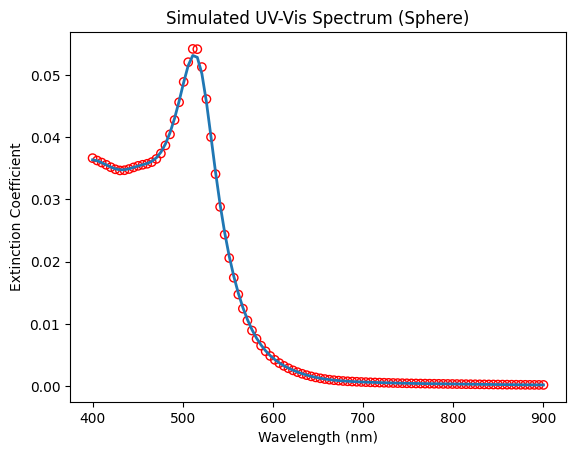

In [14]:
em = torch.Tensor([1.33])
wavelengths = torch.linspace(400, 900, 100)
spectra_sphere = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    spectra_sphere[i] = sphere_extinction(wl, em)

y_hat = gaussian_filter(spectra_sphere,  sigma=1.0)
plt.scatter(wavelengths, 
            spectra_sphere.detach().numpy(), 
            marker='o', 
            facecolors='none', 
            edgecolors='r'
            )
plt.plot(wavelengths, y_hat.detach().numpy(), lw=2.0)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction Coefficient")
plt.title("Simulated UV-Vis Spectrum (Sphere)")
plt.show()

In [6]:
def nanorod_extinction(wavelength, aspect_ratio_mu, aspect_ratio_sigma, em):
    aspect_ratio = LogNormal(aspect_ratio_mu, aspect_ratio_sigma)
    n_samples = 10000
    ar_samples = aspect_ratio.rsample((n_samples, ))
    flags = ar_samples>1.0

    e1, e2 = gold_dielectric_function(wavelength)
    scale = (2 * np.pi * (em**1.5)) / (3 * wavelength)
    
    e = torch.sqrt(1 - (1 / ar_samples[flags])**2)
    PA = ( (1 - e**2)/ e**2 ) * ( ((1/ (2 * e)) * torch.log((1 + e) / (1 - e))) - 1 )
    PB = 0.5 * (1 - PA) 
    PC = 0.5 * (1 - PA)
    gamma = []
    for P in [PA, PB, PC]:
        gj = (e2/ (P**2) )/( ( e1 + (((1-P)/P)*em) )**2 + e2**2)
        gamma.append(gj)
    ext = scale*(torch.stack(gamma).mean(dim=1).sum())

    return ext    

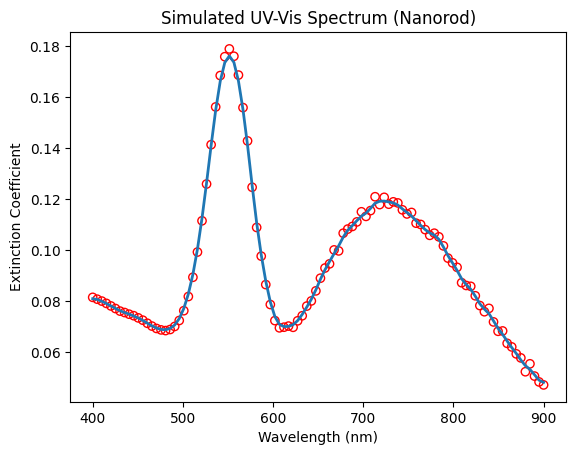

In [7]:
aspect_ratio_mu = torch.Tensor([2.0])
aspect_ratio_sigma = 0.3*aspect_ratio_mu
em = torch.Tensor([4.0])
wavelengths = torch.linspace(400, 900, 100)
spectra_nanorod = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    spectra_nanorod[i] = nanorod_extinction(wl, 
                                            aspect_ratio_mu, 
                                            aspect_ratio_sigma, 
                                            em
                                            )

y_hat = gaussian_filter(spectra_nanorod,  sigma=1.0)

plt.scatter(wavelengths, 
            spectra_nanorod.detach().numpy(), 
            marker='o', 
            facecolors='none', 
            edgecolors='r'
            )
plt.plot(wavelengths, y_hat.detach().numpy(), lw=2.0)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction Coefficient")
plt.title("Simulated UV-Vis Spectrum (Nanorod)")
plt.show()